*Author: Luke Sherman*

*Published: 2025-02-20*

*Last Updated: 2025-02-20*

In [22]:
import os, time

import pandas as pd
from matplotlib import pyplot as plt


import redivis



## Mosaiks Tutorial - Querying Redivis for native resolution grid features

The first step in using MOSAIKS is downloading a set of features. This tutorial will demonstrate how to query Redivis for native resolution (.01 x .01 degree) grid features over a small geographic area. 

For many users and for global scale analyses, it may be preferable to download coarsened global grid files or ADM aggregations. See [api.mosaiks.org](api.mosaiks.org) for more information.


### Step 1 - Make a Redivis account

Go to [Redivis.com](https://redivis.com/) and create an account. Once you have a Redivis account, you will have full access to the MOSAIKS data on Redivis.

### Step 2 - Access the table

In [17]:
## These variables will not change
user = redivis.user("sdss")
dataset = user.dataset("mosaiks")

#### Now, let's query the dataset so that it prompts us to authenticate
For more information on authnetication with Redivis see: https://apidocs.redivis.com/rest-api/authorization


In [6]:
## Now, let's run this first query. This will ask us to use a browser

#dataset.list_tables() # This output is hard to read

## Modification of the above so that it is a bit easier to read
[item.name for item in dataset.list_tables()]

['0.1 x 0.1 Deg - Area Weighted',
 '0.1 x 0.1 Deg - Pop weighted',
 '0.25. x 0.25 Deg Grid',
 'mosaiks_2019_planet',
 'coarsened_0.1_x_0.1_deg_pop_weighted_mosaiks',
 'coarsened_0.1_x_0.1_deg_area_weighted_mosaiks',
 '1 x 1 Deg Grid',
 'Administrative Region Aggregations']

Some of these tables are just used for indexing of uploaded files. There are 3 that may be queried for features:

1. 'mosaiks_2019_planet' : This table contains the global, native resolution features (.01 x .01 degree).
2. 'coarsened_0.1_x_0.1_deg_area_weighted_mosaiks' : This table contains the features coarsend to .1 x .1 degree using area weights.
3. 'coarsened_0.1_x_0.1_deg_pop_weighted_mosaiks' : This table contains the features coarsend to .1 x .1 degree using population weights from GHS-POP.

In this notebook, we're going to query for native resolution features


In [10]:
table_name = "mosaiks_2019_planet" # Table name for native resolution grid features
table = dataset.table(table_name)

### Step 3 - Get the bounds for the area we want to query

We're going to load boundaries from Natural Earth using cartopy. Alternatively, you can also just read in a shapefile locally or import your own geospatial data.

Let's suppose that we're interested in Nebraska. This is an ADM1 region, so we will need an ADM1 shapefile.

In [11]:
import geopandas as gpd
from cartopy.io import shapereader


resolution = '50m' #Coarse resolution
category = 'cultural'
#name = 'admin_0_countries'

name = 'admin_1_states_provinces'
shpfilename = shapereader.natural_earth(resolution, category, name)

geo_df = gpd.read_file(shpfilename)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 scale rank,2,AUS-2651,2651,AU-WA,None,AU,6,Western Australia,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((113.13181 -25.95199, 113.14823..."
1,Admin-1 scale rank,2,AUS-2650,2650,AU-NT,None,AU,6,Northern Territory,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((129.00196 -25.99901, 129.00196..."
2,Admin-1 scale rank,2,AUS-2655,2655,AU-SA,None,AU,3,South Australia,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((129.00196 -31.69266, 129.00196..."
3,Admin-1 scale rank,2,AUS-2657,2657,AU-QLD,None,AU,5,Queensland,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((138.00196 -25.99901, 138.00174..."
4,Admin-1 scale rank,2,AUS-2660,2660,AU-TAS,None,AU,5,Tasmania,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((147.31246 -43.28038, 147.34238..."


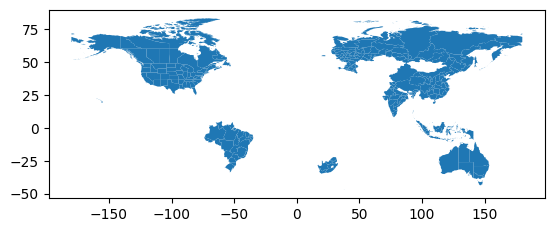

In [12]:
geo_df.plot() ## This looks like it has complete data for the US at least.
geo_df.head()

In [13]:
nebraska_shp = geo_df[geo_df["name"].str.contains("nebraska", case=False) ]  # Search, not case sensitive

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
78,Admin-1 scale rank,2,USA-3532,3532,US-NE,http://en.wikipedia.org/wiki/Nebraska,US,1,Nebraska,NE|Nebr.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-102.02449 40.00112, -102.02454 40.1..."


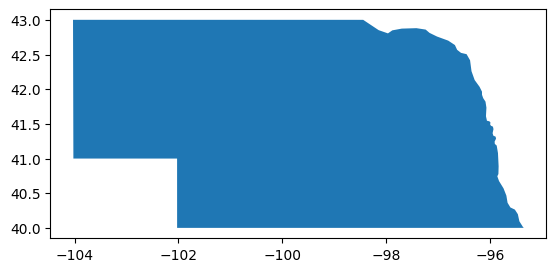

In [14]:
nebraska_shp.plot()
nebraska_shp.head()

This looks like the area we wanted to query! Now we just want the bounding box:

In [15]:
xmin, ymin, xmax, ymax = nebraska_shp.total_bounds

### Step 4 - Query Redivis for the data

In [19]:
# Recall that we set the table name in Step 2

start_time = time.time()

# In the below, we are using a standard SQL query. 
query = dataset.query(f""" 
    SELECT * 
    FROM {table_name}
    WHERE lon > {xmin}
    AND
    lon < {xmax}
    AND
    lat > {ymin}
    AND
    lat < {ymax}
""")
df = query.to_pandas_dataframe()
end_time = time.time()

print(f"Time elapsed = { (end_time-start_time)/60} minutes")

  0%|          | 0/260400 [00:00<?, ?it/s]

Time elapsed = 3.9721538464228314 minutes


In [20]:
df.head()

,lon,lat,shapeGroup,adm2_shapeID_geoBoundaries,adm1_shapeID_geoBoundaries,X_0,X_1,X_2,X_3,X_4,...,X_3990,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999
0,-95.885,40.235,USA,52423323B40677029402754,66186276B73402293045483,0.062559,0.118751,0.03856,0.042983,0.071997,...,0.046237,0.037501,0.094493,0.09917,0.038835,0.267125,0.373557,0.200487,0.080659,0.036315
1,-95.415,42.615,USA,52423323B93733047686760,66186276B63937528568220,0.032695,0.04667,0.061263,0.004588,0.044732,...,0.027651,0.053488,0.128208,0.097244,0.033558,0.182988,0.282241,0.148985,0.013496,0.024707
2,-95.805,42.525,USA,52423323B54538757084750,66186276B63937528568220,0.079816,0.232958,0.072994,0.074009,0.102005,...,0.063977,0.065533,0.253655,0.095197,0.028492,0.16949,0.907811,0.276051,0.067189,0.052975
3,-95.405,40.435,USA,52423323B76022746373485,66186276B13694661525286,0.060607,0.124777,0.086268,0.018061,0.080836,...,0.094921,0.138727,0.326514,0.232302,0.104634,0.303597,0.874386,0.24914,0.085601,0.133244
4,-95.635,41.445,USA,52423323B19646678689776,66186276B63937528568220,0.136287,0.250153,0.188607,0.057517,0.182507,...,0.238263,0.296108,0.632367,0.557276,0.241037,0.700652,1.242273,0.450147,0.26056,0.228096


### Step 5- Let's visualize the data to make sure it's what we expected

<Axes: >

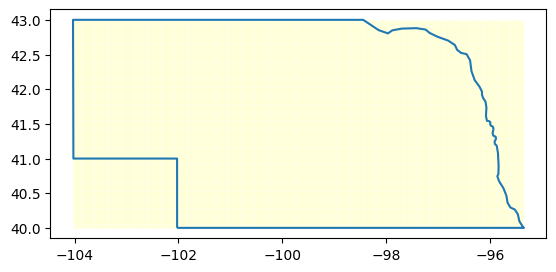

In [21]:
fig, ax =plt.subplots()

ax.scatter(df["lon"],df["lat"], s = .0001, color="yellow")  ## Plot points

nebraska_shp.exterior.plot(ax=ax)

#### The yellow points cover Nebraska! Seems like we indeed have the data that we wanted!